# Train mini-ML model on 3d pose points

Train a random forest. 

Ideas:
* add age as feature to CSV -> this could be used as a feature in training(but introduces bias)

Learnings: 
* it helps to have 3D-components of bone vectors
* it helps to only keep the important bones
* confidence and validity do not help training a RF

Future work:
* Improve by median prediction of multiple artifacts
* make more robust: small model = few params
* XGboost
* try simple linear regression, select best features
* data augmentation

## Setup

In [1]:
# !pip install openmesh==1.1.6 threevis==0.1.0.post25

In [13]:
%reload_ext autoreload
%autoreload 2

from joblib import dump, load
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

REPO_DIR = Path(os.getcwd()).parents[5]
sys.path.append(str(REPO_DIR))

from constants import SKELETON_CGM
from train_util import get_artifact_id_from_path, get_features_from_fpath, plot_history, get_path_from_artifact_id, prepare_df, get_joints_from_fpath
from qa_config_pose3dpoints import RESULT_CONFIG, DATA_CONFIG
from config_train import CONFIG_TRAIN

from cgmml.common.evaluation.eval_utils import calculate_performance, calculate_performance_mae_artifact
from cgmml.common.evaluation.eval_utilities import calculate_and_save_results
from cgmml.common.evaluation.CV.evaluation import MINIMUM_CHILD_HEIGHT_IN_CM, MAXIMUM_CHILD_HEIGHT_IN_CM

In [14]:
DATA_DIR = REPO_DIR / 'data'
DATASET_DIR = REPO_DIR / 'data/datasets/anon-pose3dpoints-23k-v3'; DATASET_DIR  # anon-pose3dpoints-27k-v2
NUM_ARTIFACTS_TO_SHOW = 3

INTERESTING_COLUMNS = ['height', 'weight', 'muac', 'scantype', 'abs_error']

# Eval
USE_FILTER_LOW_QUALITY_ARTIFACT = True

In [15]:
# import warnings
# warnings.filterwarnings('ignore')

## Create dataset split

In [16]:
SHOULD_CREATE_DATASET_SPLIT = False
if SHOULD_CREATE_DATASET_SPLIT:
    df = pd.read_csv(DATASET_DIR / 'metadata.csv')

    # Split
    scan_id_series = df.scan_id.unique()
    train_set_tmp, test_set = train_test_split(scan_id_series, test_size=0.1, random_state=1)
    train_set, val_set = train_test_split(train_set_tmp, test_size=0.1, random_state=1)

    print('Unique scan_ids:', scan_id_series.shape)
    print('Unique Train/val/test scans:', train_set.shape, val_set.shape, test_set.shape)

    # Create new dataframe column and fill according to the split
    df.loc[:, 'dset_split'] = np.NaN
    df.loc[df.scan_id.isin(train_set), 'dset_split'] = 'train'
    df.loc[df.scan_id.isin(val_set), 'dset_split'] = 'val'
    df.loc[df.scan_id.isin(test_set), 'dset_split'] = 'test'

    print('Train/val/test artifacts:', df[df['dset_split'] == 'train'].shape, df[df['dset_split'] == 'val'].shape, df[df['dset_split'] == 'test'].shape)
    assert np.all(df['dset_split'].isin(['train', 'val', 'test']))

    df.to_csv(DATASET_DIR / 'metadata_with_dset_split.csv')
    del df

In [17]:
df_ = pd.read_csv(DATASET_DIR / 'metadata_with_dset_split.csv')
assert np.all(df_.dset_split.isin(['train', 'val', 'test']))
df_.rename(columns={"scan_type": "scantype"}, inplace=True)
df_ = df_.astype({'scantype': 'str'})
artifact_ids_all = list(df_['artifact_id'])

In [18]:
# Get artifacts obj file names from data dir
obj_files_paths_ = list(sorted(DATASET_DIR.glob('*.obj')))
obj_files_names_all = [get_artifact_id_from_path(path) for path in obj_files_paths_]

In [19]:
# Show that the CSV has more files than we have artifacts
x = set(artifact_ids_all)
y = set(obj_files_names_all)
z = x.intersection(y)
len(x), len(y), len(z)

(27919, 23031, 23031)

In [20]:
# Only keep the rows for which we have artifacts
df_all = df_[df_.artifact_id.isin(obj_files_names_all)]

# Sort dataframe by artifact_id
df_all = df_all.set_index('artifact_id')
df_all = df_all.sort_index()

# Make sure that file names are in the same order as the dataframe
assert np.all(obj_files_names_all == df_all.index)

df_all.shape, len(obj_files_names_all)

((23031, 13), 23031)

In [21]:
# Filter by scan type
df = df_all[df_all.scantype.isin(CONFIG_TRAIN.SCAN_TYPES_TO_USE)]
artifact_ids = list(df.index)

obj_files_names = [name for name in obj_files_names_all if name in artifact_ids]
obj_files_paths = [get_path_from_artifact_id(name, DATASET_DIR) for name in obj_files_names]

print(df.shape, len(obj_files_paths))
df.head()

(3069, 13) 3069


,Unnamed: 0,scan_id,order,depthmap_path,rgb_path,height,weight,muac,scan_version,scantype,measurement_date,scan_date,dset_split
artifact_id,,,,,,,,,,,,,
0816b862-8e1b-11eb-941c-dbaed44346b6,262,0816b860-8e1b-11eb-941c-ab8a1eff68ab,1.0,1616726354112/3428cc7a-002f-45ee-82f8-c4618ce8...,1616726346829/27fd9dca-694c-4593-b464-bb767f30...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f00-8e1b-11eb-941c-cf2a8c1b927f,263,0816b860-8e1b-11eb-941c-ab8a1eff68ab,2.0,1616726354229/a1a926f5-a9eb-40d2-ab11-60e2fb7a...,1616726354149/39af2c90-d6d6-4bab-bcf8-33320a2c...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f02-8e1b-11eb-941c-9b7184a99229,255,0816b860-8e1b-11eb-941c-ab8a1eff68ab,3.0,1616726354264/8a3d2cec-b395-4c44-a29e-323164e2...,1616726354194/ee2cf646-503a-4137-bc45-d9db5e4c...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f04-8e1b-11eb-941c-a3304ecd1294,256,0816b860-8e1b-11eb-941c-ab8a1eff68ab,4.0,1616726360883/c1dd0daa-f682-4129-a11a-50735d20...,1616726361201/126b2218-34cb-4c80-97bc-c68ece9b...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train
08183f06-8e1b-11eb-941c-6b69cb6bd4f4,257,0816b860-8e1b-11eb-941c-ab8a1eff68ab,5.0,1616726364111/587634dc-69d5-425b-9b1f-91c2ac1e...,1616726364587/5ccdb1e7-2c09-4c5e-80f4-aa5779dd...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59,train


In [22]:
# Make sure that file names are in the same order as the dataframe
assert np.all(obj_files_names == df.index)

# df and obj_files_names are now prepared!

## Feature engineering

In [23]:
# Create columns by looking at first child's features
obj_file_path = obj_files_paths[0]
child_features = get_features_from_fpath(obj_file_path, config_train=CONFIG_TRAIN)

num_samples = len(obj_files_paths); print(num_samples)
num_features = len(child_features); print(num_features)

3069
46


In [24]:
# Check features of 1 child
# child_features

In [25]:
features_array = np.empty([num_samples, num_features])
features_array[:] = np.NaN

for artifact_index, obj_file_path in enumerate(obj_files_paths):
    child_features = get_features_from_fpath(obj_file_path, config_train=CONFIG_TRAIN)
    assert len(child_features) == 46
    values = np.array(list(child_features.values()))
    assert np.all(~np.isnan(values)), child_features
    features_array[artifact_index] = np.array(list(child_features.values()))
assert np.all(~np.isnan(features_array)), "Not all features were calculated"
features_array.shape

(3069, 46)

In [26]:
# Split train, eval, test set according to df

X = features_array

# We can assume that X and df are in the same order

df_train = df[df['dset_split'] == 'train']
df_val = df[df['dset_split'] == 'val']
df_test = df[df['dset_split'] == 'test']

y_train = df_train.height
y_val = df_val.height
y_test = df_test.height

X_train = X[np.where(df['dset_split'] == 'train')]
X_val = X[np.where(df['dset_split'] == 'val')]
X_test = X[np.where(df['dset_split'] == 'test')]
# df_train.shape, X_train.shape

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2597, 46) (2597,)
(211, 46) (211,)
(261, 46) (261,)


In [27]:
df_val.scan_id.unique().shape

(16,)

## Mean Baseline

In [28]:
# Mean baseline
y_true = y_test
height_mean = df.height.mean()
y_pred = [height_mean for _ in range(X_test.shape[0])]
mean_absolute_error(y_true, y_pred)

7.344897248345525

## Random Forest

In [29]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0)
regr.fit(X_train, y_train);

In [30]:
# Evaluate
y_true = df_val.height
y_pred = regr.predict(X_val)
mean_absolute_error(y_true, y_pred)

1.2416195323702288

In [31]:
# Save model
model_name = f'2021q4-points3d-rf-height-27k-{"and".join(CONFIG_TRAIN.SCAN_TYPES_TO_USE)}'
MODEL_PATH = DATA_DIR / f'models/pose3dpointsModel/{model_name}.joblib'
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
dump(regr, MODEL_PATH)
regr = load(MODEL_PATH)

In [32]:
# Check the predicted height is realistic

if USE_FILTER_LOW_QUALITY_ARTIFACT:
    y_pred = regr.predict(X_val)
    print('amount of all samples:', y_pred.shape[0])
    indexes = np.where((MINIMUM_CHILD_HEIGHT_IN_CM < y_pred) & (y_pred < MAXIMUM_CHILD_HEIGHT_IN_CM))[0]
    print('amount of sane samples:', indexes.shape[0])
    
    y_pred_ = y_pred[indexes]
    y_true_ = df_val.height.iloc[indexes]
    
    mae = mean_absolute_error(y_true_, y_pred_)
    print(f'mae (filtered): {mae:.2f}')

amount of all samples: 211
amount of sane samples: 211
mae (filtered): 1.24


In [33]:
# Evaluate per scan step
for scantype in DATA_CONFIG.CODES:
    indexes = np.where(df_val.scantype == scantype)[0]
    y_true_ = df_val.iloc[indexes].height
    if not X_val[indexes].any():
        continue
    y_pred_ = regr.predict(X_val[indexes])
    mae = mean_absolute_error(y_true_, y_pred_)
    print(f'{scantype}: {mae:.2f}')
    

200: 1.00
201: 1.49


In [34]:
df_val.loc[:, 'GT'] = df_val['height']
df_val.loc[:, 'predicted'] = y_pred
df_val.loc[:, 'error'] = df_val['GT'] - df_val['predicted']

csv_fpath = REPO_DIR / 'data/outputs/pose3dpointmodel/test_mae_artifact_level_pose3dpointmodel.csv'
calculate_and_save_results(df_val.copy(), 'pose3dpointmodel', csv_fpath,
                           DATA_CONFIG, RESULT_CONFIG, fct=calculate_performance_mae_artifact)

/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [35]:
df_val_grouped = prepare_df(df_val.copy())
csv_out_fpath = REPO_DIR / 'data/outputs/pose3dpointmodel/pose3dpointmodel.csv'
calculate_and_save_results(df_val_grouped, 'pose3dpointmodel', csv_out_fpath, DATA_CONFIG, RESULT_CONFIG, fct=calculate_performance)

In [36]:
df_val.loc[:, 'abs_error'] = np.abs(df_val['error'])

(-3.0, 3.0)

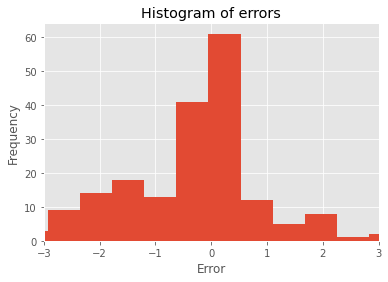

In [37]:
df_val['error'].hist(bins=20);
plt.ylabel('Frequency'); plt.xlabel('Error'); plt.title('Histogram of errors');
plt.xlim(-3, 3)

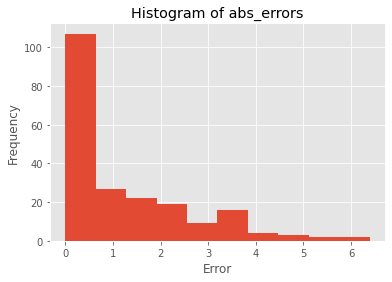

In [38]:
df_val['abs_error'].hist();
plt.ylabel('Frequency'); plt.xlabel('Error'); plt.title('Histogram of abs_errors');

In [39]:
# Sort by error
df_errors = df_val.sort_values('abs_error', ascending=False)

In [39]:
# Show some results
# for i in range(20):
#     pred = regr.predict([X_test[i]])
#     print(pred[0], 'actual:', y_test[i])

## Neural Network

In [112]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2021-10-25 10:20:53.788130: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-25 10:20:53.794177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [113]:
# hyperparameters
model = models.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear")
])
LR = 0.003
BATCH_SIZE = 16

# Training code
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# checkpoint
MODEL_CKPT_FILENAME = "best_model.ckpt"
best_model_path = str(DATA_DIR / f'models/pose3dpointsModel/outputs/{MODEL_CKPT_FILENAME}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=-1
)

history = model.fit(
    dataset_train.repeat(5).batch(BATCH_SIZE),
    validation_data=dataset_validation.batch(BATCH_SIZE),
    epochs=60,
    verbose=2,
    callbacks=[checkpoint_callback]
)

model = tf.keras.models.load_model(best_model_path)
loss, mae = model.evaluate(dataset_train.batch(BATCH_SIZE))
val_loss, val_mae = model.evaluate(dataset_validation.batch(BATCH_SIZE))
print(f'mae: {mae}, val_mae: {val_mae}')

Epoch 1/60


2021-10-25 10:20:55.548390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


801/801 - 2s - loss: 9710.9111 - mae: 15.6771 - val_loss: 303.6802 - val_mae: 16.6023


2021-10-25 10:20:57.007817: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 2/60
801/801 - 1s - loss: 138.6321 - mae: 5.5728 - val_loss: 189.7032 - val_mae: 12.8536
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 3/60
801/801 - 1s - loss: 229.7914 - mae: 5.1681 - val_loss: 105.3646 - val_mae: 9.0168
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 4/60
801/801 - 1s - loss: 359.1142 - mae: 4.9562 - val_loss: 73.8101 - val_mae: 7.2304
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 5/60
801/801 - 2s - loss: 81.6698 - mae: 4.3352 - val_loss: 83.1051 - val_mae: 7.7708
Epoch 6/60
801/801 - 2s - loss: 46.9886 - mae: 4.0133 - val_loss: 68.3543 - val_mae: 6.8525
IN

In [114]:
history

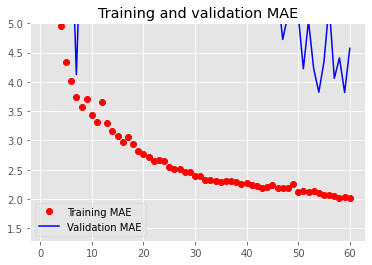

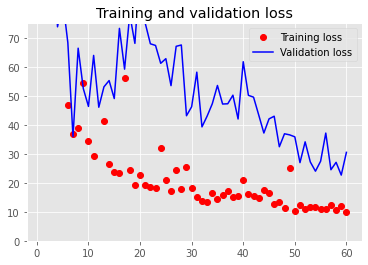

In [115]:
plot_history(history)

## Visualize good and bad predictions 

Visualization in 3D using [threevis](https://gitlab.vci.rwth-aachen.de:9000/threevis/threevis)

In [40]:
import threevis as tv
import openmesh as om

def draw_3d(mesh):
    ctx = tv.Context(width=320, height=240)  # width=640, height=480)  # Create Context
    vertices = mesh.points()  # Get vertices and faces from the mesh
    ctx.draw_edges(vertices, SKELETON_CGM)
    ctx.draw_vertices(vertices, point_size=4, colors='red')  # Draw a point for each vertex
    ctx.display()

In [41]:
# Show a sample visualization

m = om.read_trimesh(str(obj_files_paths[13]))
draw_3d(m)

/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

In [42]:
def draw_artifact(artifact_id):
    obj_file_path = get_path_from_artifact_id(artifact_id, DATASET_DIR)
    m = om.read_trimesh(str(obj_file_path))
    draw_3d(m)

    # print confidence values
    joints = get_joints_from_fpath(obj_file_path)
    confidences = [joint.confidence for joint in joints]
    print('mean confidence:', np.mean(confidences), 'confidences:', confidences)

In [43]:
# Worst predictions
for artifact_id, row in df_errors[INTERESTING_COLUMNS].head(NUM_ARTIFACTS_TO_SHOW).iterrows():
    print(row)
    draw_artifact(artifact_id)

height        65.6
weight         6.2
muac          13.2
scantype       201
abs_error    6.389
Name: 5cd39d24-8d7e-11eb-8070-eb9804262805, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.8707971134606529 confidences: [0.9496195912361145, 0.9883992075920105, 0.9486600756645203, 0.846113383769989, 0.9814605116844177, 0.9514914751052856, 0.9351633191108704, 0.9560878276824951, 0.9427306056022644, 0.8027063012123108, 0.8516762852668762, 0.7915952205657959, 0.799345850944519, 0.7765870690345764, 0.9196963310241699, 0.9747452735900879, 0.38747259974479675]
height          65.6
weight           6.2
muac            13.2
scantype         201
abs_error    6.22767
Name: 5cd21681-8d7e-11eb-8070-97ffd77677d9, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9025913512005526 confidences: [0.9487193822860718, 0.9853890538215637, 0.9802499413490295, 0.9217121601104736, 0.9327092170715332, 0.9314011931419373, 0.9005709886550903, 0.9904966950416565, 0.9232797026634216, 0.9507977962493896, 0.9292566776275635, 0.9319279789924622, 0.9074966311454773, 0.8937076926231384, 0.8774420619010925, 0.6461656093597412, 0.692730188369751]
height        65.6
weight         6.2
muac          13.2
scantype       201
abs_error    5.247
Name: 5cd39d22-8d7e-11eb-8070-c7ca0b7cbe0c, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9022189063184402 confidences: [0.9672528505325317, 0.9841410517692566, 0.9768686890602112, 0.907110333442688, 0.9457719326019287, 0.9346726536750793, 0.9244446754455566, 0.9193437695503235, 0.9600549936294556, 0.9172250628471375, 0.8419860005378723, 0.8713352680206299, 0.8259167075157166, 0.8959978222846985, 0.9252196550369263, 0.914449155330658, 0.6259307861328125]


In [44]:
# Best predictions
for artifact_id, row in df_errors[INTERESTING_COLUMNS].tail(NUM_ARTIFACTS_TO_SHOW).iterrows():
    print(row)
    draw_artifact(artifact_id)


height             77.2
weight              8.1
muac                 13
scantype            201
abs_error    0.00270387
Name: c6945782-8e15-11eb-b846-df16fcd892e7, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9521945960381452 confidences: [0.9486386179924011, 0.9660835266113281, 0.9503285884857178, 0.961123526096344, 0.9505278468132019, 0.9332586526870728, 0.9326596856117249, 0.9753425717353821, 0.9503716826438904, 0.9748344421386719, 0.9435330033302307, 0.8953573703765869, 0.9223560094833374, 1.0061542987823486, 0.9828365445137024, 0.9248010516166687, 0.9691007137298584]
height             77.2
weight              8.1
muac                 13
scantype            200
abs_error    0.00270387
Name: ee7da083-8e15-11eb-b846-e7f3bf68c2c3, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9554788926068474 confidences: [0.9387661218643188, 0.9653109908103943, 1.0008316040039062, 0.9595987200737, 0.9536786675453186, 0.9415545463562012, 0.9592225551605225, 0.9482951760292053, 0.9443694353103638, 0.9756999611854553, 0.9545162916183472, 0.8955169320106506, 0.8814199566841125, 1.0270453691482544, 0.9836527705192566, 0.9208871722221375, 0.9927749037742615]
height            77.2
weight             8.1
muac                13
scantype           201
abs_error    0.0021007
Name: c6945780-8e15-11eb-b846-6f0fac607c8f, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9514719002387103 confidences: [0.9761954545974731, 0.9723303914070129, 0.9665803909301758, 0.9545192122459412, 0.9854325652122498, 0.9345369935035706, 0.9405630826950073, 0.9701181054115295, 0.9520596265792847, 0.9434309005737305, 0.9633864760398865, 0.8769930601119995, 0.9328523874282837, 0.944925844669342, 0.9589463472366333, 0.9479107856750488, 0.9542406797409058]
